# Dataset from Kaggle

In [ ]:
!pip install -q kaggle

from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"littlepeanutaan","key":"84d004fb4d442b6ba94eddaba252a1d2"}'}

In [ ]:
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d 'shonenkov/isic2018'

100% 2.58G/2.58G [01:33<00:00, 30.1MB/s]
100% 2.58G/2.58G [01:33<00:00, 29.6MB/s]


In [ ]:
!unzip isic2018.zip

# Import libraries

In [ ]:
import torchvision.models as models
from glob import glob
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import cv2
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
from torchsummary import summary
from sklearn.model_selection import train_test_split
torch.cuda.manual_seed(10)
from torch import optim
import torch.nn.functional as F
import torch.nn as nn

# Take dataset

In [ ]:
%cd '/content/'

/content


In [ ]:
!ls

ISIC2018_Task3_Training_GroundTruth.csv  isic2018.zip  README.md
ISIC2018_Task3_Training_Input		 kaggle.json   sample_data


## Get labels

In [ ]:
target = pd.read_csv('/content/ISIC2018_Task3_Training_GroundTruth.csv')
target_arr = np.array(target)
label = target_arr[:,1::]
label.shape

(10015, 7)

In [ ]:
# target_arr[:5,:]

In [ ]:
mapLabels = {0: 'Mel', 1: 'NV', 2: 'BCC', 3: 'AKIEC', 4: 'BKL', 5: 'DF', 6: 'VASC'}
encodingLabel = []
labelName = []
for idx in target.index:
  indexOfLabel = np.argmax(target_arr[idx, 1::])
  encodingLabel.append(indexOfLabel)
  labelName.append(mapLabels[indexOfLabel])

labelName = np.expand_dims(np.array(labelName), axis = 1)
encodingLabel = np.expand_dims(np.array(encodingLabel), axis = 1)

## Get images

In [ ]:
dataFolder = '/content/ISIC2018_Task3_Training_Input/ISIC2018_Task3_Training_Input'
paths = glob(dataFolder + '/*.jpg')
imgData = []
for path in paths:
  im = cv2.imread(path)
  im = cv2.resize(im, (224, 224))
  imgData.append(im)

imgData = np.array(imgData)

In [ ]:
# imgData.shape

### Mean and Standard R,G,B

In [ ]:
R, G, B = [], [], []
for image in imgData:
  R.append(image[:,:,2])
  G.append(image[:,:,1])
  B.append(image[:,:,0])

In [ ]:
meanR = np.mean(np.array(R), dtype=np.float32())
meanG = np.mean(np.array(G), dtype=np.float32())
meanB = np.mean(np.array(B), dtype=np.float32())
mean = [meanR/255, meanG/255, meanB/255]

In [ ]:
stdR = np.std(np.array(R), dtype=np.float32())
stdG = np.std(np.array(G), dtype=np.float32())
stdB = np.std(np.array(B), dtype=np.float32())
std = [stdR/255, stdG/255, stdB/255]

In [ ]:
print(mean, std)

[0.763038725011489, 0.5456446628944547, 0.5700463986864277] [0.14092793184168198, 0.1526129030713848, 0.16997076296338848]


### Data for training

In [ ]:
dataFolder = '/content/ISIC2018_Task3_Training_Input/ISIC2018_Task3_Training_Input'
paths = glob(dataFolder + '/*.jpg')
paths.sort()
paths = np.array(paths)
paths = np.expand_dims(paths, axis = 1)
paths.shape

(10015, 1)

In [ ]:
data = np.concatenate((paths, encodingLabel, labelName), axis = 1)

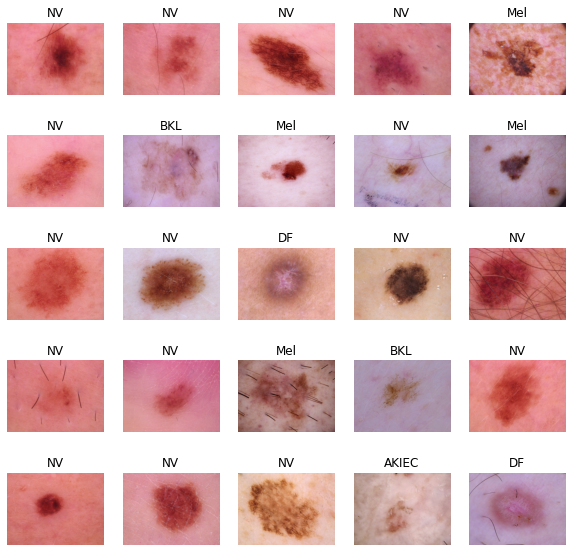

In [ ]:
f, ax = plt.subplots(5,5, figsize = (10,10))
arr = []
for i in range(25):
    im = cv2.imread(data[i,0])
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    ax.ravel()[i].imshow(im)
    ax.ravel()[i].set_axis_off()
    ax.ravel()[i].set_title(data[i, 2])

In [ ]:
train, valid = train_test_split(data, test_size = 0.1)

### Chuẩn hoá dữ liệu

In [ ]:
class getData(Dataset):
  def __init__(self, X):
    self.paths = X[:,0]
    self.normalize = transforms.Normalize(mean, std)
    self.targets = X[:,1]

  def __len__(self): return len(self.paths)

  def __getitem__(self, ix):
    path = self.paths[ix]
    target = self.targets[ix].astype(float)
    im = cv2.imread(path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (224, 224))
    im = torch.tensor(im)
    im = im.float()
    im = im.permute(2,0,1)
    im = self.normalize(im)
    return im.float(), torch.tensor(target).type(torch.LongTensor)

In [ ]:
trainData = getData(train)
trainDataLoader = DataLoader(trainData, batch_size = 64, shuffle = True)
validData = getData(valid)
validDataLoader = DataLoader(validData, batch_size = 64, shuffle = False)

# Training

In [ ]:
# Get model:
model = models.vgg16(pretrained = True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
for param in model.parameters():
  param.requires_grad = False

model.avgpool = torch.nn.AdaptiveAvgPool2d((1,1))
model.classifier = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(512, 128), torch.nn.ReLU(), torch.nn.Dropout(0.2), torch.nn.Linear(128,7))
lossFunc = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [ ]:
def meanAccuracy(scores, Y):
  prob = torch.softmax(scores, dim = 1)
  isCorrect = (Y.squeeze()) == prob.argmax(dim = 1)
  return isCorrect.sum()/prob.size(0)

In [ ]:
#Training Phase
def trainingPhase(trainDataLoader, model, opt, criterion, epoch):
    batchLoss = 0
    batchAcc = 0
    meanTrainLoss = 0
    meanTrainAcc = 0
    model.train()
    for i, data in enumerate(trainDataLoader):
        img, label = data
        img = img.to('cuda')
        label = label.to('cuda')
        opt.zero_grad()
        scores = model(img)
        loss = criterion(scores, label)
        batchLoss += loss.detach().item()
        batchAcc +=meanAccuracy(scores, label).cpu()
        loss.backward()
        opt.step()
        if (i+1)%200 == 0:
            print('epoch:{}|iter:[{}/{}]|train_loss:{:.3f}|train_acc:{:.3f}'.format(epoch,i+1,len(trainDataLoader),batchLoss/(i+1),batchAcc/(i+1)))
    meanTrainLoss = batchLoss/len(trainDataLoader)
    meanTrainAcc = batchAcc/len(trainDataLoader)

    return meanTrainLoss, meanTrainAcc

In [ ]:
#Validating phase:
def validatingPhase(validDataLoader, model, criterion, epoch):
    batchLoss = 0
    batchAcc = 0
    meanValLoss = 0
    meanValAcc = 0
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(validDataLoader):
            img, label = data
            img = img.to('cuda')
            label = label.to('cuda')
            scores = model(img)
            loss = criterion(scores, label)
            batchLoss += loss.detach().item()
            batchAcc += meanAccuracy(scores, label).cpu()
        print('epoch:{}|val_loss:{:.3f}|val_acc:{:.3f}'.format(epoch,batchLoss/len(validDataLoader),batchAcc/len(validDataLoader)))
        meanValLoss = batchLoss/len(validDataLoader)
        meanValAcc = batchAcc/len(validDataLoader)
    return meanValLoss, meanValAcc

In [ ]:
def trainModel(model, epoch, lr, trainDataLoader, valDataLoader):
    model = model.to('cuda')
    criterion = torch.nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr = lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, patience = 1, factor = 0.4, mode = 'max', verbose = True)
    trainLoss = []
    trainAcc = []
    valLoss = []
    valAcc = []
    bestValAcc = 0
    count = 0
    for i in range(1, epoch+1):
        #training:
        meanTrainLoss, meanTrainAcc = trainingPhase(trainDataLoader, model, opt, criterion, i)
        #validating:
        meanValLoss, meanValAcc = validatingPhase(valDataLoader, model, criterion, i)
        scheduler.step(meanValLoss)
        trainLoss.append(meanTrainLoss)
        trainAcc.append(meanTrainAcc)
        valLoss.append(meanValLoss)
        valAcc.append(meanValAcc)
        if meanValAcc > bestValAcc:
            bestValAcc = meanValAcc
            count = 0
            print('Best accuracy record: [epoch{}], valLoss: {:.3f}, valAcc: {:.3f}'.format(i, meanValLoss, meanValAcc))
        if meanValAcc<bestValAcc: count+=1
        if count==3:
            print('After 3 epochs with no improvement, stop training. Best score recored: {}'.format(bestValAcc))
            break
    return trainLoss, trainAcc, valLoss, valAcc

### Train

In [ ]:
X, Y = next(iter(trainDataLoader))

In [ ]:
epoch = 15
lr = 1e-3
trainLoss, trainAcc, valLoss, valAcc = trainModel(model, epoch, lr, trainDataLoader , validDataLoader)

In [ ]:
f, ax = plt.subplots(1, 2, figsize = (20, 5))
ax[0].plot(trainLoss, label='Training loss')
ax[0].plot(valLoss,label='Validating loss')
ax[1].plot(trainAcc, label = 'Training accuracy')
ax[1].plot(valAcc, label = 'Validating accuracy')

plt.legend()
plt.savefig('Loss and Accuracy of myModel with Augmented Data.jpg')
plt.show()

# Save model

In [ ]:
torch.save(model.state_dict(), 'VGG16_pretrained.pth')

# Test model

In [ ]:
model = model.to('cuda')
y_pred = []
y = []
acc = 0
model.eval()
with torch.no_grad():
    for i, data in enumerate(validDataLoader):
        imgs,labels = data
        imgs,labels = imgs.to('cuda'),labels.to('cuda')

        scores = model(imgs)
        acc += meanAccuracy(scores,labels)
        prod = torch.softmax(scores,dim=1)
        pred = prod.max(dim=1)[1]

        y_pred.extend(pred.cpu().detach().numpy())
        y.extend(labels.cpu().detach().numpy())
    mean_acc = acc/len(validDataLoader)
print(" Test accuracy: {:.3f}%".format(mean_acc*100))

 Test accuracy: 71.898%


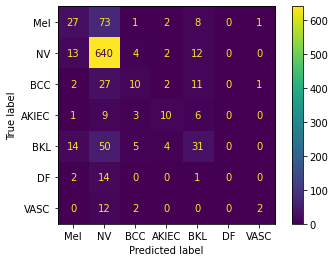

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
class_list = list(mapLabels.values())
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(cm,display_labels = class_list).plot()
plt.savefig('Confusion matrix of myModel with Augmented Data.jpg')

In [ ]:
report = classification_report(y, y_pred, target_names = class_list)
plt.savefig('Classification report of myModel with Augmented Data.jpg')
print(report)

              precision    recall  f1-score   support

         Mel       0.46      0.24      0.32       112
          NV       0.78      0.95      0.86       671
         BCC       0.40      0.19      0.26        53
       AKIEC       0.50      0.34      0.41        29
         BKL       0.45      0.30      0.36       104
          DF       0.00      0.00      0.00        17
        VASC       0.50      0.12      0.20        16

    accuracy                           0.72      1002
   macro avg       0.44      0.31      0.34      1002
weighted avg       0.66      0.72      0.67      1002



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 432x288 with 0 Axes>